## Applying the XGBoost algorithm ##

In [1]:
# %load_ext autoreload
# %autoreload 2

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from config import EXPERIMENT, RUN_NAME, ARTIFACT_DIR
from logger import logger
from mlflow_utils import evaluate_binary, log_mlflow

In [26]:
thedf = 'df9'

In [27]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'thedf': thedf,
              'artifact_dir': ARTIFACT_DIR}

In [28]:
# input dataset
input_file = "../../data/processed/all_combined_training.csv"
validation_file = "../../data/processed/all_combined_validation.csv"

In [29]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [30]:
dfc.tail(3) 

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [31]:
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)

## Power consumption per capita

In [32]:
dfc['Kw_per_capita'] = dfc['Kw']/df['population']
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date,Kw_per_capita
83391,2013,7,9,15,251.254583,61.03000,-69.62,403,463.473224,4.600244,2013-07-09,0.623461
68409,2014,10,23,9,984.463167,62.20071,-75.65,1483,1347.844242,-3.605078,2014-10-23,0.663832


## Reduce data to essential columns

In [33]:
dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','hour','lon','Temp'],
         axis = 1, inplace = True)

In [34]:
dfc.sample(2)

,lat,date,Kw_per_capita
34704,58.45424,2013-12-18,0.636182
234200,60.01732,2015-09-26,0.744633


## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [35]:
dfc['lat'].value_counts()

58.45424    26280
62.20071    26280
61.03000    26280
59.31042    26280
62.41657    26280
58.10006    26280
60.01732    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [36]:
# create a list of dataframe names, key=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9']
key=[]
for i in range(9):
    key.append('df'+str(i+1))
# print(key)

# create a list of dataframes
s=key.copy()
i=0
for lat in dfc['lat'].value_counts().keys():
#     print(lat)
    s[i]=dfc[dfc['lat']==lat]
#     print(name.head(2))
#     print('\n')
    i=i+1

# create dict using the list of df names and dataframes
my_dict = dict(zip(key, s))

In [37]:
my_dict[thedf].sample(5)

,lat,date,Kw_per_capita
210050,58.68,2015-12-24,0.609696
186033,58.68,2013-03-28,0.647381
184135,58.68,2013-01-08,0.545117
206904,58.68,2015-08-14,0.460899
190343,58.68,2013-09-23,0.560510


### Aggregate the data by date, which means sum up all the hourly consumptions

In [38]:
dff=my_dict[thedf].groupby('date')['Kw_per_capita'].sum().reset_index()
dff=dff.sort_values(by='date')
dff.head(2)

,date,Kw_per_capita
0,2013-01-01,14.132166
1,2013-01-02,15.028397


In [39]:
# see if there are any missing values
dff.isna().sum()

date             0
Kw_per_capita    0
dtype: int64

## Feature engineering

In [40]:
def build_training_data(data, history_size = 3, target_size = 1):
    """
    history_size denotes the number of columns used as history. For e.g. we use the past 3 days as history, 
    this means we create 3 columns (yesterday, yesterday -1, yesterday -2) as the feature columns. 
    
    target_size denotes the number of columns we want to predict. If we want to predict the following 2 days, 
    this creates 2 columns (tomorrow, tomorrow+1) as the label/target columns
    
    data has to be a dataframe, whose columns time series.
    """
    start_row = history_size
    end_row = len(data) - target_size
    cols2keep = []
    
    # create the input data columns
    cols = range(1, history_size+1)
    for col in cols:
        data[str(col)+'d_prior']=data['Kw_per_capita'].shift(col, axis=0)
        cols2keep.append(str(col)+'d_prior')
        
    # create the label columns
    label_cols = range(1, target_size+1)
    for col in label_cols:
        data['label_'+str(col)]=data['Kw_per_capita'].shift(1-col, axis=0)
        cols2keep.append('label_'+str(col))
        
    # drop the rows that are useless
    rows2drop = [*range(history_size)] + [*range(len(data)-target_size+1, len(data))]
    data.drop(df.index[rows2drop], axis=0, inplace=True)
    # slice dataframe by columns
    data = data.loc[:, cols2keep]
    return data
    
data = dff.copy()        
data = build_training_data(data)

## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [41]:
train_data = data[:int(data.shape[0]*0.8)]
test_data = data[int(data.shape[0]*0.8):]

In [42]:
train_data.sample(2)

,1d_prior,2d_prior,3d_prior,label_1
18,17.157820,16.495665,16.284855,16.620488
655,13.932767,13.934006,14.234430,13.262562


In [43]:
output_cols=[]
for i in data.columns:
    if 'label' in i:
        output_cols.append(i)

In [44]:
X_train = train_data.copy().drop(columns=output_cols)
X_test = test_data.copy().drop(columns=output_cols)

y_train = train_data.copy()[output_cols]
y_test = test_data.copy()[output_cols]

In [45]:
y_train.sample(3)

,label_1
498,13.335633
24,16.289367
49,15.332891


## Log models and train

In [46]:
# model_name = 'XGB'
# model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
# model.fit(X_train, 
#           y_train, 
#          eval_set=[(X_train, y_train),(X_test, y_test)],
#          eval_metric='mae')
# test_pred = model.predict(X_test)

In [50]:
import mlflow
n_estimators=10
with mlflow.start_run():
        model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = n_estimators, seed = 123)
        model.fit(X_train, y_train)

        test_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        mae = mean_absolute_error(y_test, test_pred)

        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)

        mlflow.log_param("number of trees", n_estimators)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

  RMSE: 0.8086821202681487
  MAE: 0.6264838017316913


/home/lj/Document/DataScience/envs/remote_com_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [51]:
# Predictions on the train dataset
train_pred = model.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE : % f" %(train_rmse))

RMSE :  0.656095


/home/lj/Document/DataScience/envs/remote_com_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [52]:
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))

RMSE :  0.808682


### For RMSE, the value of the difference **Abs(y_test - test_pred)** plays a role, 
- if **|y_test-test_pred|<1**, then the RMSE is going to be small, regardless of whether it's a good prediction or not.
- to solve this, we use the Mean Absolute Percentage Error for the relative error.

In [53]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) 

In [54]:
err_tr = mean_absolute_percentage_error(y_train,train_pred)
print("train MAPE : % f" %(err_tr))

err_tst = mean_absolute_percentage_error(y_test,test_pred)
print("test MAPE : % f" %(err_tst))

train MAPE :  0.129288
test MAPE :  0.125379


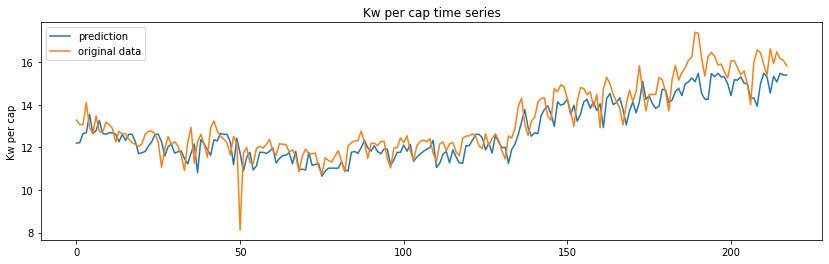

In [55]:
test_series = pd.Series(test_pred)
orig_series = pd.Series(test_data['label_1']).reset_index().drop(columns=['index'])['label_1']
#                         [int(data.shape[0]*0.8):])
fig, ax = plt.subplots(1, 1, figsize=(14, 4), sharex=True)

test_series.plot(ax=ax, label='prediction')
orig_series.plot(ax=ax, label='original data')
ax.set(title = 'Kw per cap time series', ylabel = 'Kw per cap')
plt.legend()
plt.show()

- other features
- other error function than RMSE

In [56]:
!pip list

Package                       Version
----------------------------- ---------
alembic                       1.4.3
ansiwrap                      0.8.4
appdirs                       1.4.4
asn1crypto                    1.4.0
asttokens                     2.0.5
attrs                         21.4.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
black                         22.1.0
brotlipy                      0.7.0
certifi                       2021.10.8
cffi                          1.15.0
chardet                       3.0.4
click                         8.0.4
cloudpickle                   1.6.0
colorama                      0.4.4
configparser                  5.0.1
convertdate                   2.4.0
cryptography                  36.0.1
cycler                        0.11.0
databricks-cli                0.12.1
debugpy                       1.5.1
decorator                     5.1.1
docker                        5.0.3
docker-pycreds                0.4.0
entrypoints 